In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from auctioneer import *
from slope_bot import *
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [37]:
start_date =datetime.now() - relativedelta(minutes = 10000)
start_date = start_date.replace(second=0, microsecond=0)
# end_date = pd.to_datetime(datetime.now())
# security = 'BTC/USD'
# pull_closes(, start_date, end_date)

In [55]:
datetime(2023, 8,2, 12)

datetime.datetime(2023, 8, 2, 12, 0)

In [64]:
security = 'ETH/USD'

In [65]:
from datetime import datetime
client = CryptoHistoricalDataClient()
request_params = CryptoBarsRequest(
    symbol_or_symbols=[security],
    timeframe=TimeFrame.Day,
    start=datetime(2023, 7,12, 12),
    # end=datetime.now(),
    # limit = 100000,
)

bars_df = client.get_crypto_bars(request_params).df
bars_df

,,open,high,low,close,volume,trade_count,vwap
symbol,timestamp,,,,,,,
ETH/USD,2023-07-13 05:00:00+00:00,1654.58,1712.13,1579.76,1595.49,1249.3287,11688.0,1636.261421


KeyError: "None of ['symbol', 'timestamp'] are in the columns"

open      high       low     close  \
symbol  timestamp                                                           
BTC/USD 2023-07-01 00:00:00+00:00  28894.82  28909.27  28875.04  28909.27   
        2023-07-01 00:01:00+00:00  28890.49  28890.49  28875.04  28879.48   
        2023-07-01 00:02:00+00:00  28879.35  28926.00  28875.00  28891.91   
        2023-07-01 00:03:00+00:00  28890.13  28893.89  28890.13  28893.89   
        2023-07-01 00:04:00+00:00  28897.02  28910.18  28875.00  28902.66   
...                                     ...       ...       ...       ...   
        2023-07-14 02:55:00+00:00  25025.00  25366.91  25000.00  25097.80   
        2023-07-14 02:56:00+00:00  25049.21  25097.80  24919.66  24979.35   
        2023-07-14 02:57:00+00:00  24979.35  25055.72  24920.00  24920.00   
        2023-07-14 02:58:00+00:00  24920.00  25055.72  24900.00  25054.98   
        2023-07-14 02:59:00+00:00  24990.00  25100.67  24990.00  25073.21   

                                    volume  trade_count          vwap  
symbol  timestamp                                                      
BTC/USD 2023-07-01 00:00:00+00:00  0.01529         13.0  28890.197214  
        2023-07-01 00:01:00+00:00  0.04695         17.0  28879.803144  
        2023-07-01 00:02:00+00:00  0.11371         41.0  28894.480134  
        2023-07-01 00:03:00+00:00  0.00600          4.0  28891.386667  
        2023-07-01 00:04:00+00:00  0.03210         15.0  28899.615393  
...                                    ...          ...           ...  
        2023-07-14 02:55:00+00:00  3.48284        151.0  25033.854259  
        2023-07-14 02:56:00+00:00  1.10968         96.0  24939.339625  
        2023-07-14 02:57:00+00:00  0.84385         63.0  24948.303133  
        2023-07-14 02:58:00+00:00  0.18515         57.0  24940.330237  
        2023-07-14 02:59:00+00:00  0.70879         40.0  25050.729755  

[15646 rows x 7 columns]

In [106]:
s3 = create_s3()
data = load_data(s3, None, None)
model, scalers = download_model(s3)
# model = encoder_model(HISTORY_STEPS, TARGET_STEPS, 3)
# model.load_weights('../../models/checkpoint.ckpt')
# scalers = joblib.load('../../models/scalers.gz')

13:37:43: Reading data
/Users/landon/opt/anaconda3/envs/auctioneer/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [33]:
def one_day(date, portfolio, data, model, scalers):
    df = data.loc[:date].copy()
    predictions = predict_forward(df, model, scalers, HISTORY_STEPS)
    terminal_prices = {df.columns[i]: predictions[-1,i] for i in range(df.shape[1])}

    orders = {}
    for symbol in terminal_prices.keys():
        current_price = df[symbol].values[-1]
        predicted_price = terminal_prices[symbol]

        if predicted_price > current_price:
            amount = 1
            orders[symbol] = {'action': 'buy', 'amount': amount}
        elif predicted_price < current_price:
            amount = portfolio.holdings.get(symbol, 0)
            amount = max([1, amount // 10])
            orders[symbol] = {'action': 'sell', 'amount': amount}
    
    return orders

In [51]:
def backtest(data, model, scalers):
    portfolio = Portfolio(STARTING_BALANCE, data)


    for i, date in enumerate(data.index):
        if i < HISTORY_STEPS:
            continue    
        orders = one_day(date, portfolio, data, model, scalers)
        if orders is not None:
            portfolio.execute(date, orders)

        if (i % 100) == 0:
            print(i)
    return portfolio

def windowed_backtest(data,model, scalers, window_size, stride = 1):
    logger.info('Windowed test')
    results = []
    for i in range(0, data.shape[0]-window_size, stride):
        tmp = data.iloc[i:i+window_size]
        result = backtest(tmp,model, scalers)
        log = result.transaction_log_summary()

        long_result = long_return(tmp, STARTING_BALANCE)
        results.append({
            'StartDate': data.index[i], 
            'EndValue': result.value()['Total'],
            'LongValue': long_result,
            'N_Buys': log['buys'][0],
            'N_Sells': log['sells'][0],
        })
    
    return pd.DataFrame(results)

In [107]:
start_index = data.index.get_loc(data.loc[END_DATE].index[0]) - HISTORY_STEPS

In [108]:
eval_data = data.iloc[start_index:]
eval_data = eval_data.head(1000).bfill().ffill()
eval_data.shape

(1000, 3)

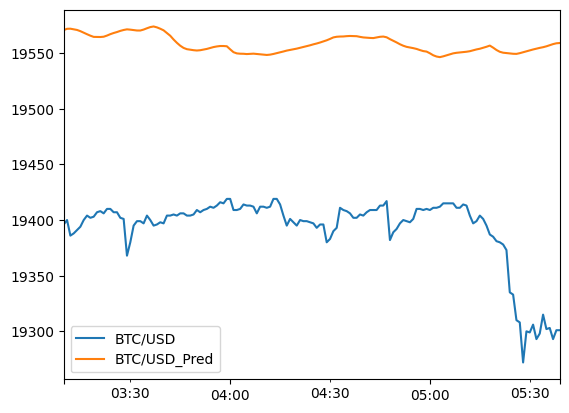

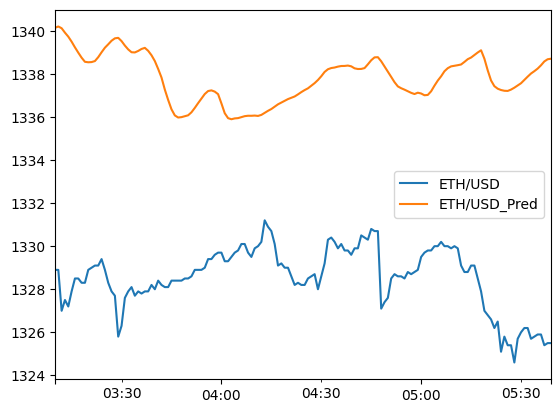

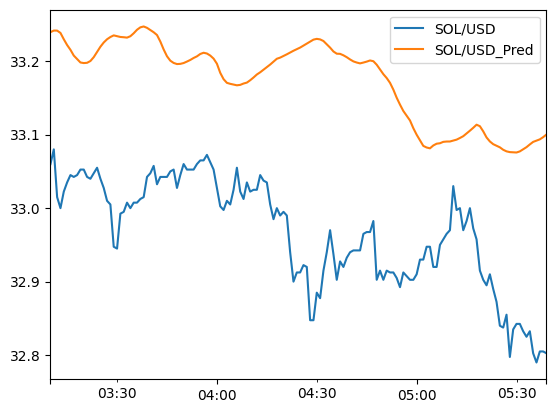

In [109]:
preds = []
truths = []
for i in range(400, 550):
    df = eval_data.iloc[:i]
    predictions = predict_forward(df, model, scalers, HISTORY_STEPS)
    terminal_prices = {df.columns[i]: predictions[-1,i] for i in range(df.shape[1])}
    actual_prices = eval_data.iloc[i+TARGET_STEPS]
    preds.append(terminal_prices)
    truths.append(actual_prices)

truths = pd.DataFrame(truths)
preds = pd.DataFrame(preds)
preds.columns = [c+'_Pred' for c in preds.columns]
preds.index = truths.index
df = truths.join(preds)
for c in data.columns:
    df[[d for d in df.columns if c in d]].plot()

In [54]:
portfolio = Portfolio(STARTING_BALANCE, eval_data)

In [55]:
x = backtest(eval_data, model, scalers)

250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975


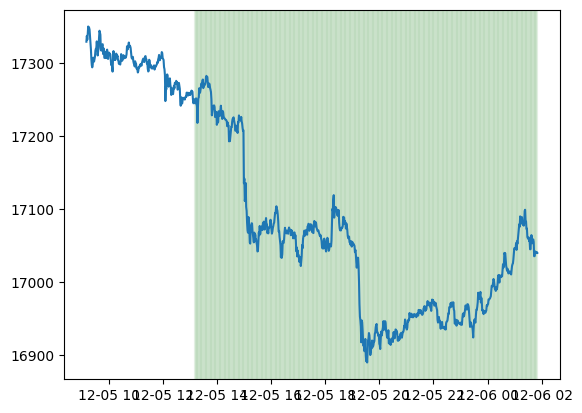

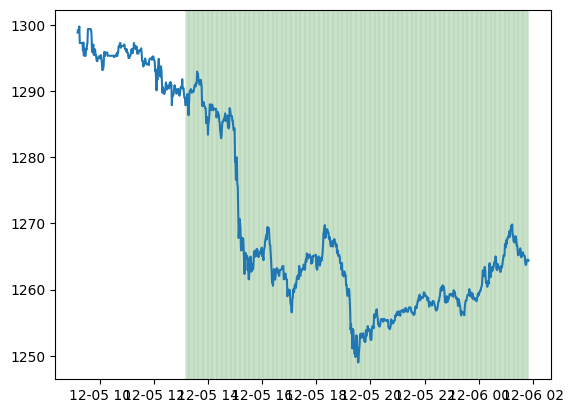

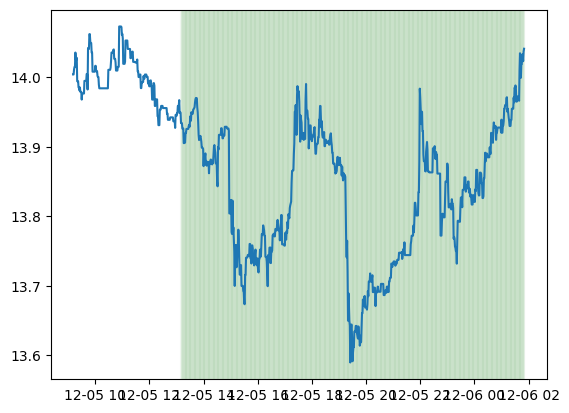

In [56]:
x.plot_transactions()

In [65]:
preds = predict_forward(eval_data.head(250), model, scalers)
preds = pd.DataFrame(preds)
preds.columns = [c+'_Pred' for c in eval_data.columns]
truth = eval_data.iloc[250:250+TARGET_STEPS].copy()
preds.index = truth.index

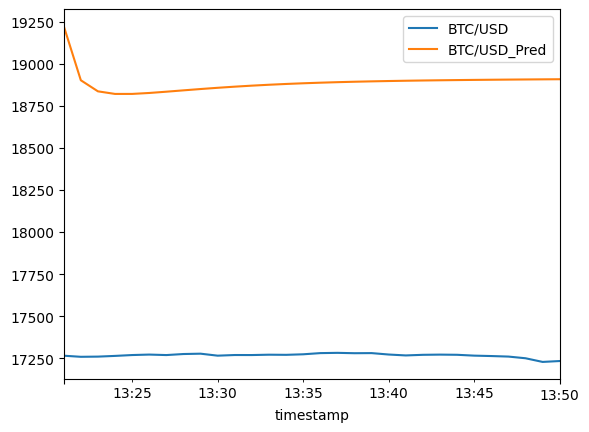

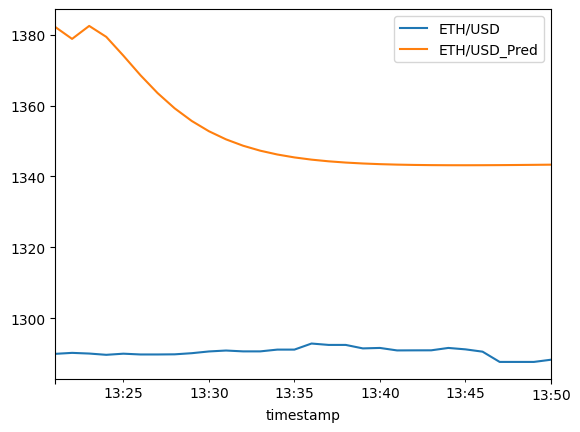

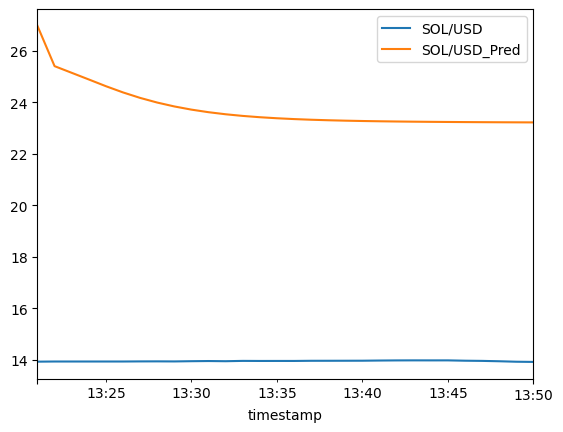

In [75]:
df = truth.join(preds)
